### Glauber Dynamics of an Ising Model


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

## Background

In [ ]:
class GlauberDynamics:
    """
    A class for simulating the spin flips in an Ising Model

    Args:
        grid (array): Lattice of particles' spins, -1 = down | +1 = up
        temp (float, opt.): Temperature of the model. Default is 0
        seed (float, opt.): Random seed for simulation, Default is None
        store_history (bool, opt.): Keeps a record of past steps. Default is False.

    Attributes:
        history (list, opt.): Record of past grids

    Methods:
        step: Simulate a single step of the process
        run: Simulate the process for a given number of steps

    Notes:
        Algorithm used: https://en.wikipedia.org/wiki/Glauber_dynamics
    """
    def __init__(self, grid, temp= 0, seed= None, store_history= False):
        np.random.seed(seed)
        self.grid = grid
        self.temp = temp
        # boundary conditions, edges are given values of 0
        self.grid_copy = np.pad(grid, pad_width= 1)
        self.history = [self.grid_copy.copy()]
        self.store_history = store_history
        
        pass
    
    def step(self):
        """Chooses a random lattice site and determines if it flips."""
        i = np.random.randint(1, len(self.grid_copy) - 1)
        j = np.random.randint(1, len(self.grid_copy[0]) - 1)

        spin_sum = self.grid_copy[i+1][j] + self.grid_copy[i][j+1] + self.grid_copy[i-1][j] + self.grid_copy[i][j-1]
        del_E = 2*self.grid_copy[i][j]*spin_sum

        if self.temp != 0:
            p = 1/(1 + np.e**(del_E/self.temp))
        else:
            if del_E < 0:
                p = 1
            else: # assumes that non-ferromagnetic(del_E == 0) sites don't change
                p = 0

        if np.random.rand() < p:
            self.grid_copy[i][j] *= -1

        if self.store_history == True:
            self.history.append(self.grid_copy)

    @staticmethod
    def check_difference(grid1, grid2):
        """Check the total number of different sites between two grids"""
        return np.sum(grid1 != grid2)

    def run(self, n):
        """
        Simulates spin flips for n_steps.

        Args:
            n (int): The number of steps to simulate
        """    
        for i in range(n):
            self.step()
            if self.store_history == True and np.any(self.grid_copy != self.history[-1]):
                self.history.append(self.grid_copy.copy())


    def __str__(self):
        """
        Prints the current grid. Red = Up | Blue = Down | White = Boundary
        """
        plt.figure()
        plt.imshow(self.grid_copy, cmap='coolwarm')
        plt.title(f"Current State:{self.temp}")
        return ""

Test

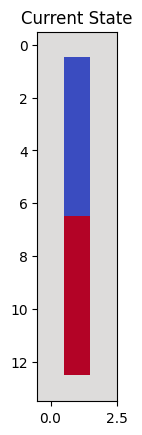

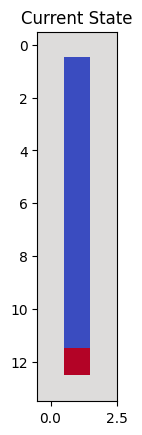

In [ ]:
myGrid = np.random.choice((-1,1), size= (1,15))
# myGrid = np.array([-1,-1,-1,-1,-1,-1,1,1,1,1,1,1])[:,None]
model = GlauberDynamics(myGrid, temp= 4, store_history= False) # Critical temp = 2.27
print(model)
model.run(1000)
print(model)



Animation

KeyboardInterrupt: 

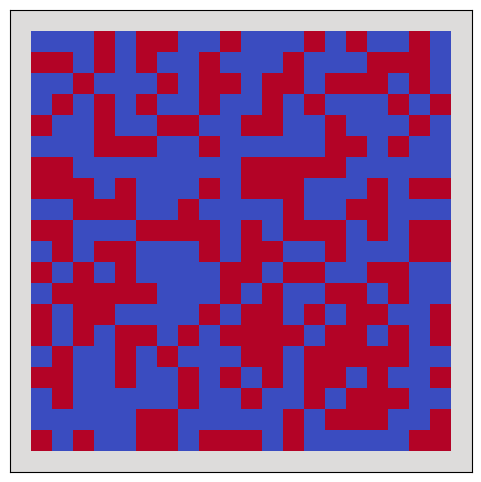

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
# TODO someone fix this plz ;-;
# Assuming frames is a numpy array with shape (num_frames, height, width)
frames = np.array(model.history).copy() 

fig = plt.figure(figsize=(6, 6))
img = plt.imshow(frames[0], vmin=-1, vmax=1, cmap="coolwarm")
plt.xticks([]); plt.yticks([])
# tight margins
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())

def update(frame):
    img.set_array(frame)

ani = FuncAnimation(fig, update, frames=frames, interval=50)
HTML(ani.to_jshtml())